# <center>Data Mining Project Code</center>

** **
## <center>*02 - XXXXXXXX*</center>

** **

Consumers today are becoming more selective about where they buy their products and where they spend their money. Consequently, it is essencial for companies to better understand their clients, being able to tailor sales and discounts to certain groups of customers.

Knowing this, the goal of this project is to divide customers of `ABCDEats Inc.` into smaller groups, whose clients have similar characteristics and purchasing behaviours.

The second  notebook of this project consists of the .......

This project was presented to the `TargetSphere Advisors`, a group of Consultants, Business Analysts and Data Scientists who focus on delivering Customer Segementation solutions for small and medium-sized businesses.

The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# Table of Contents

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>
2. [Data Cleansing](#2.-Data-Cleansing) <br><br>
    2.1 [Filling the missing values](#2.1-Filling-the-missing-values) <br><br>
    2.2 [Outlier Treatment](#2.2-Outlier-Treatment)<br><br>
3. [Feature Selection](#-3.-Feature-Selection)<br><br>
    3.1 [Univariate variables](#3.1.-Univariate-variables)<br><br>
    3.2 [Spearman Correlation](#3.2-Spearman-Correlation)


 

# 1. Importing Libraries & Data

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# To fill the missing values
from sklearn.impute import KNNImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Import external '.py' file containing the functions created and used for this analysis
import functions as f

In [2]:
dataset_name = 'preprocessed_data'

data = pd.read_csv(f'data/{dataset_name}.csv', index_col = "customer_id")
data.head(3)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,avg_order_hour,total_spend,avg_spend_prod,is_repeat_customer,weekend_orders,weekday_orders,1_7h,8_14h,15_19h,20_23h
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18.0,2,5,1,0,1,DELIVERY,DIGI,0.00,...,18.0,28.88,5.776,1,2,0,0,0,2,0
5d272b9dcb,8670,17.0,2,2,2,0,1,DISCOUNT,DIGI,12.82,...,10.5,19.21,9.605,1,2,0,0,2,0,0
f6d1b2ba63,4660,38.0,1,2,2,0,1,DISCOUNT,CASH,9.20,...,10.0,9.20,4.600,1,2,0,0,2,0,0


In [3]:
data['customer_region'] = data['customer_region'].replace(0, '0000')

<br>

# 2. Data Cleansing

## 2.1 Filling the missing values

In the previous notebook, we noticed that there were 3 columns with missing values: `customer_age`, `first_order` and `HR_0`. For the feature `first_order` we considered filling the missing values with 0, given that in these rows the last order had values of 0, meaning that the customer made their first and last order on the day that the dataset started. The last variable was deleted, since new features were created. Previously, we used the median for the feature `customer_age`, but in this notebook we will fill with the K nearest neighbor imputer.

In [ ]:
data.isna().sum()

customer_region               0
customer_age                727
vendor_count                  0
product_count                 0
is_chain                      0
first_order                 106
last_order                    0
last_promo                    0
payment_method                0
CUI_American                  0
CUI_Asian                     0
CUI_Beverages                 0
CUI_Cafe                      0
CUI_Chicken Dishes            0
CUI_Chinese                   0
CUI_Desserts                  0
CUI_Healthy                   0
CUI_Indian                    0
CUI_Italian                   0
CUI_Japanese                  0
CUI_Noodle Dishes             0
CUI_OTHER                     0
CUI_Street Food / Snacks      0
CUI_Thai                      0
promo_DELIVERY                0
promo_DISCOUNT                0
promo_FREEBIE                 0
pay_CARD                      0
pay_CASH                      0
last_promo_enc                0
payment_method_enc            0
days_bet

From the output above we can see that there are missing values in `avg_order_hour` and `days_between`, the reason for this is because for 235 customers there is no values in the hours feature.

**customer_age**

First, we are going to check the variables that have a higher correlation with `customer_age`. Doing this, we can use these variables to predict the missing value using the KNN Imputer.

In [5]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())]

corr = final_data.corr(method="pearson")

# Selecting correlations for 'customer_age'
target_variable = 'customer_age'
if target_variable in corr:
    correlations = corr[target_variable].dropna()

    most_correlated = correlations.abs().sort_values(ascending=False)

    print("Most correlated variables with customer_age:")
    print(most_correlated)
else:
    print(f"'{target_variable}' is not in the numeric dataset.")

Most correlated variables with customer_age:
customer_age                1.000000
CUI_Asian                   0.013435
last_order                  0.012604
total_spend                 0.009004
CUI_OTHER                   0.008481
CUI_Desserts                0.008296
CUI_American                0.008216
weekend_orders              0.007569
CUI_Healthy                 0.007302
days_between                0.006706
CUI_Cafe                    0.006534
15_19h                      0.006337
CUI_Chinese                 0.005799
CUI_Thai                    0.005651
CUI_Indian                  0.005628
product_count               0.005196
avg_order_hour              0.004528
CUI_Street Food / Snacks    0.004428
total_orders                0.004113
first_order                 0.003966
1_7h                        0.003654
CUI_Beverages               0.003231
8_14h                       0.003142
CUI_Japanese                0.002181
avg_spend_prod              0.002161
last_promo_enc              0.

In [6]:
# Selecting the top 6 correlated variables
top_correlated = most_correlated[1:7].index.tolist()

# Creating a new DataFrame with only the most correlated variables
selected_data = data[top_correlated + ['customer_age']]

# Applying KNN Imputer only to these variables
knn_imputer = KNNImputer(n_neighbors=10)
imputed_data = knn_imputer.fit_transform(selected_data)

# Replacing the imputed values in the original DataFrame
data['customer_age'] = imputed_data[:, selected_data.columns.get_loc('customer_age')].round().astype(int)

In [7]:
data['customer_age'].isna().sum()

0

<br>

**first_order**

Given the insights taken on the previous notebook, we will replace all missing values of the feature `first_order` to 0.

In [8]:
data['first_order'] = data['first_order'].fillna(0)

<br>

**days_between**

Since the days_between variable has missing values due to first_order, and we filled the missing values in first_order with 0, the days_between will also be 0, as the last_order is 0 when first_order was initially missing.

In [9]:
data['days_between'] = data['days_between'].fillna(0)

<br>

**avg_order_hour**

In [10]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
final_data = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())]

corr = final_data.corr(method="pearson")

# Selecting correlations for 'avg_order_hour'
target_variable = 'avg_order_hour'
if target_variable in corr:
    correlations = corr[target_variable].dropna()

    # Sorting in descending order by absolute value
    most_correlated = correlations.abs().sort_values(ascending=False)

    print("Most correlated variables with avg_order_hour:")
    print(most_correlated)
else:
    print(f"'{target_variable}' is not in the numeric dataset.")

Most correlated variables with avg_order_hour:
avg_order_hour              1.000000
1_7h                        0.539229
avg_spend_prod              0.432447
15_19h                      0.361384
CUI_Asian                   0.297054
20_23h                      0.280461
CUI_Beverages               0.173687
total_spend                 0.161352
CUI_Italian                 0.144143
CUI_OTHER                   0.128030
CUI_Desserts                0.119745
CUI_Street Food / Snacks    0.117658
CUI_Indian                  0.114107
CUI_Chicken Dishes          0.109529
CUI_Thai                    0.090638
is_chain                    0.088682
8_14h                       0.079258
CUI_Noodle Dishes           0.070234
CUI_Healthy                 0.064925
CUI_American                0.063291
first_order                 0.048099
total_orders                0.046138
weekday_orders              0.045654
CUI_Japanese                0.039187
last_promo_enc              0.036542
weekend_orders              

In [11]:
# Selecting the top 5 correlated variables 
top_correlated = most_correlated[1:6].index.tolist()

# Creating a new DataFrame with only the most correlated variables
selected_data = data[top_correlated + ['avg_order_hour']]

# Applying KNN Imputer only to these variables
knn_imputer = KNNImputer(n_neighbors=10)
imputed_data = knn_imputer.fit_transform(selected_data)

# Replacing the imputed values in the original DataFrame
data['avg_order_hour'] = imputed_data[:, selected_data.columns.get_loc('avg_order_hour')]

In [12]:
print(data['avg_order_hour'].isna().sum())

0


<br>

## 2.2 Outlier Treatment

##### Solution A - do not apply any treatment. 

In this solution, no treatment will be applied. This will allow us to test different scalers. One of the reasons to do this, is to test it with the Robust scaler, which essentially caps the outliers.

In [13]:
data_copy = data.copy()

<br>

##### Solution B - Capping outliers

In [14]:
numeric_data = data_copy.select_dtypes(include='number')
categorical_data = data_copy.select_dtypes(include='object')
boolean_columns = numeric_data.loc[:, numeric_data.isin([0, 1]).all()]

data_no_booleans = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())].copy()

From the visualizations ploted in the previous notebook, we noticed that none of the features have a normal distribution. By considering this, we are going to use the interquartile range method to cap the outliers.

In [15]:
f.cap_outliers(data_no_booleans)

In [16]:
data_capped = pd.concat([data_no_booleans, categorical_data, boolean_columns], axis=1)

<br>

##### Solution C - logarithmic tranformation

In [17]:
data_no_bool = numeric_data.loc[:, ~(numeric_data.isin([0, 1]).all())].copy()

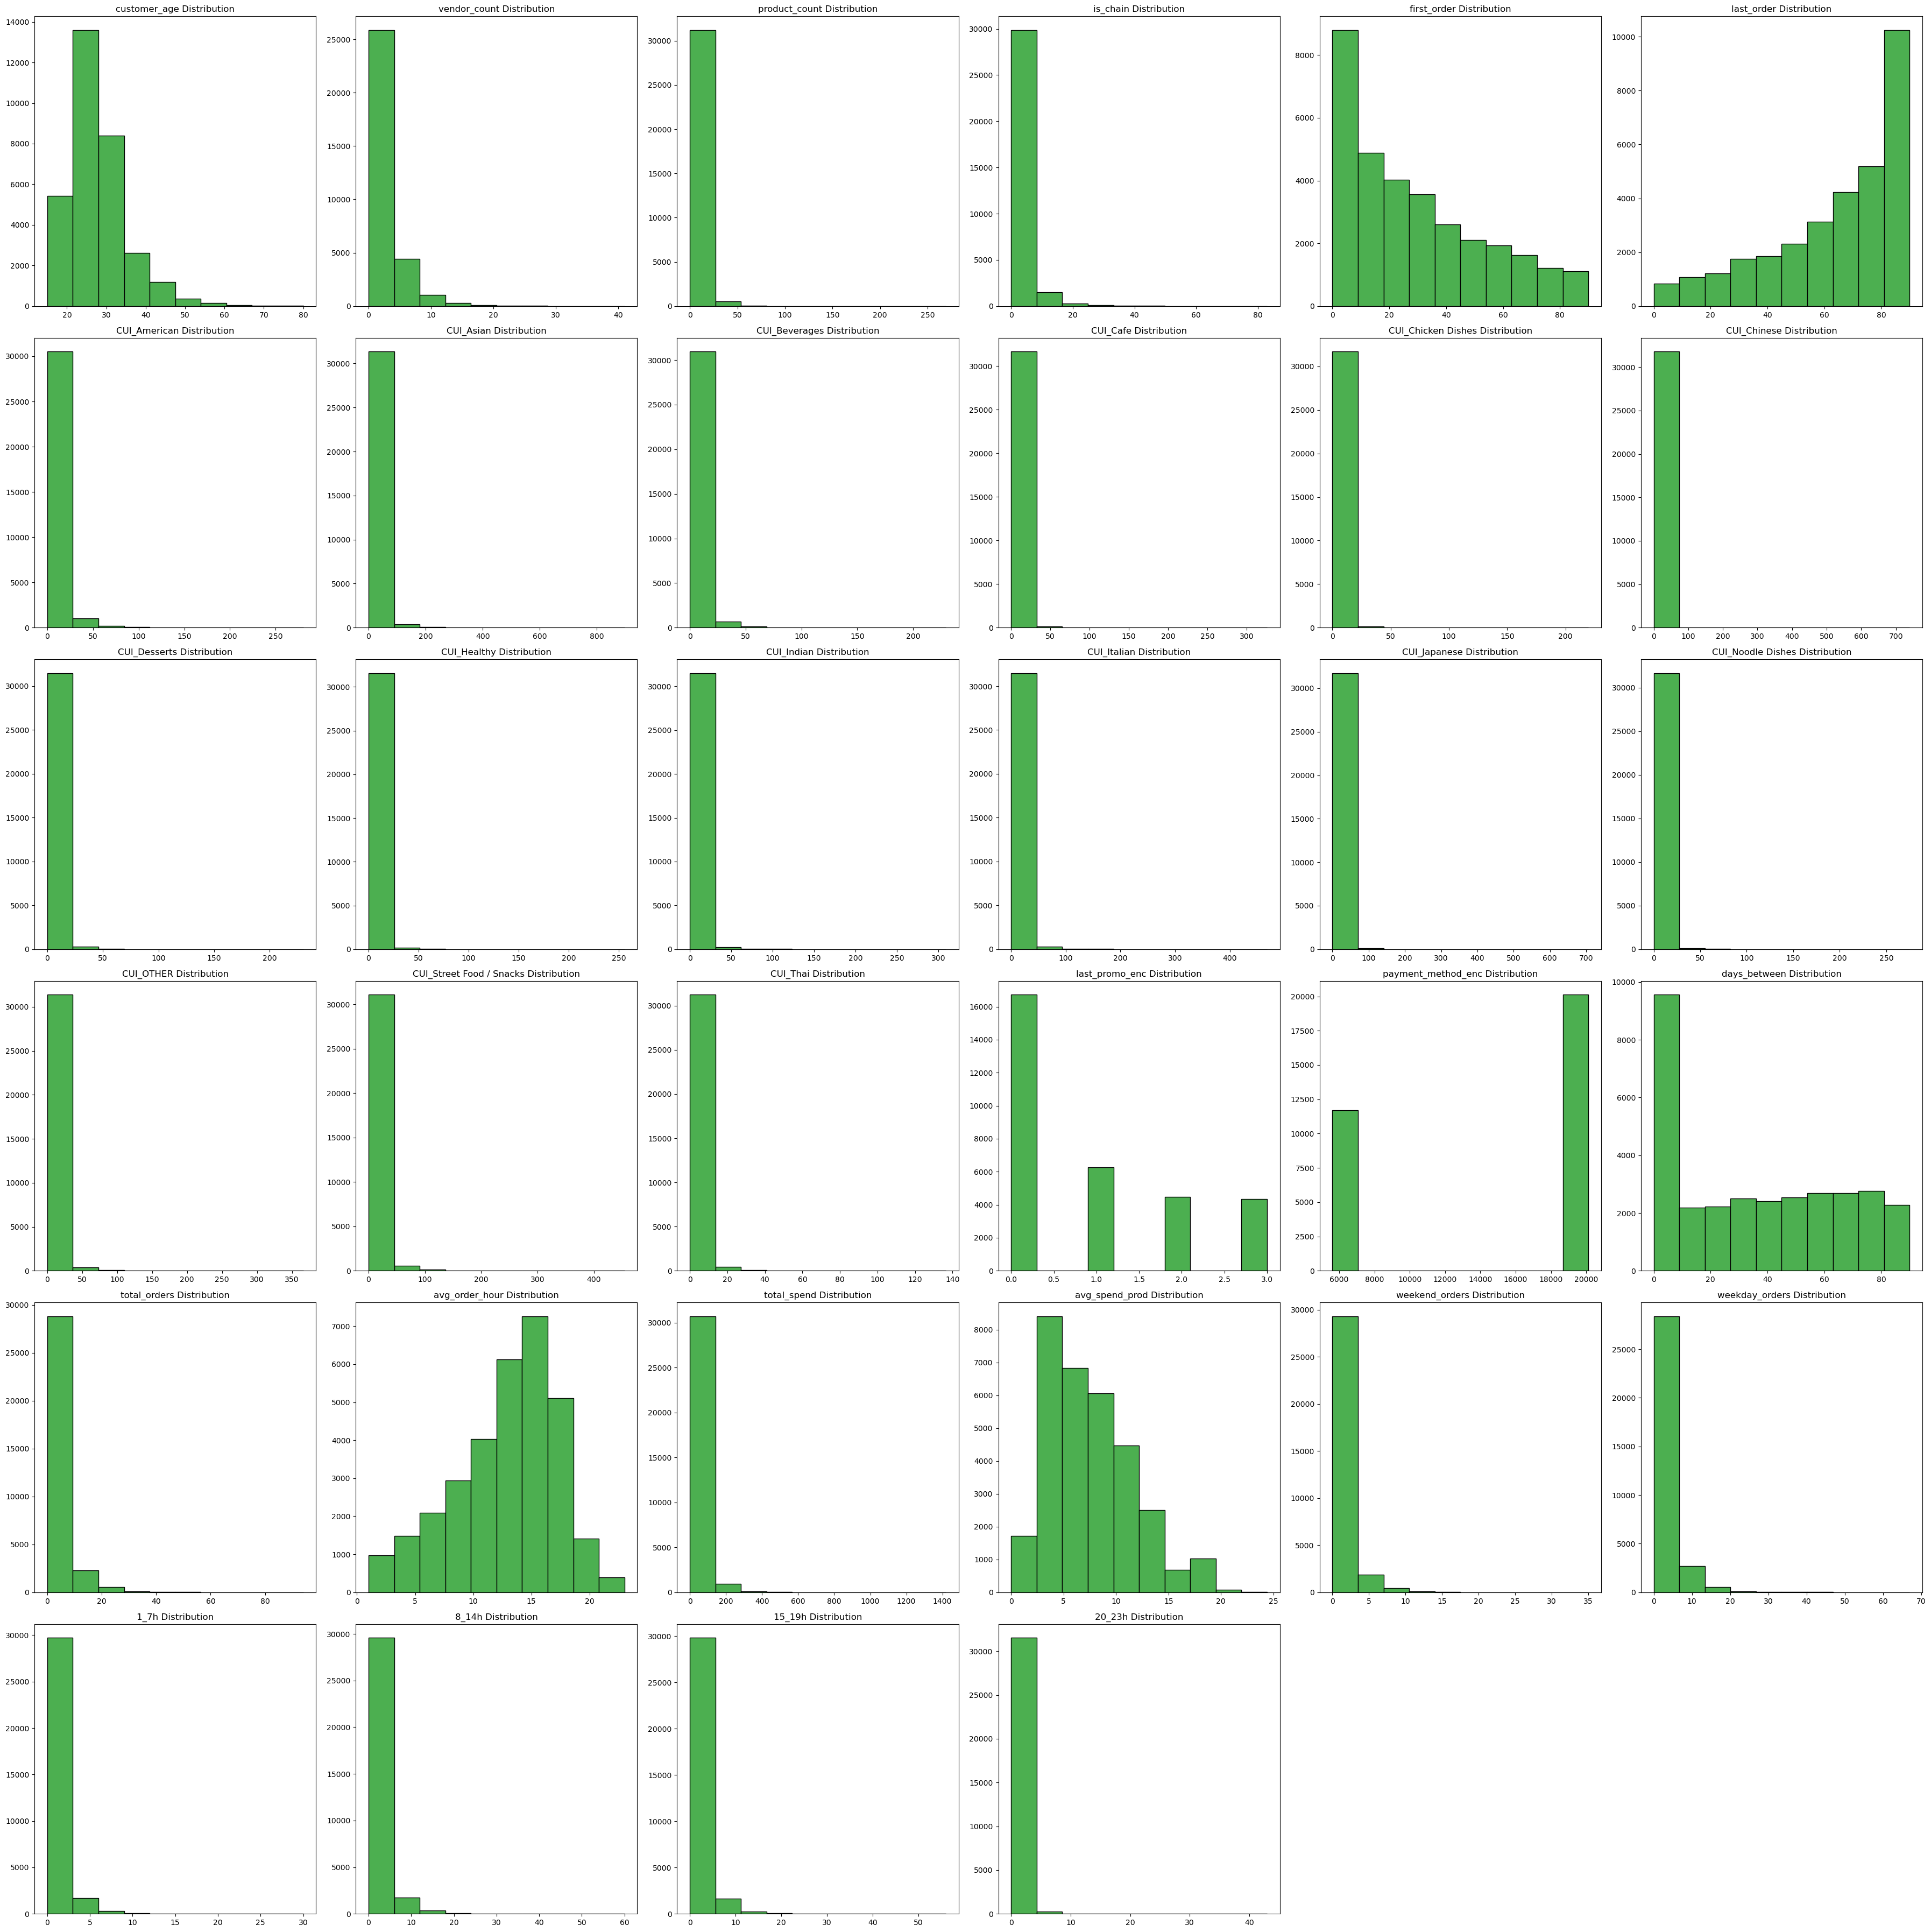

In [18]:
f.draw_histograms(data_no_bool, data_no_bool.columns, 6, 6)

From the plot below, it is clear that most of the numeric features have a Log-normal distribution, some exceptions are 

- `customer_age`: gamma distribution
- `days_between`, `first_order` and `last_order`: exponential distribution
- `avg_order_hour`:
- `avg_spend_prod`: 

Therefore, we will aply the logarithm to those features.

In [19]:
data_no_bool['customer_age'] = np.log10(data_no_bool['customer_age'])
data_no_bool['days_between'] = np.log10(data_no_bool['days_between'] + 1)
data_no_bool['first_order'] = np.log10(data_no_bool['first_order'] + 1)
data_no_bool['last_order'] = np.log10(data_no_bool['last_order'] + 1)
data_no_bool['avg_order_hour'] = np.log10(data_no_bool['avg_order_hour'])
data_no_bool['avg_spend_prod'] = np.log10(data_no_bool['avg_spend_prod'] + 1)

In [20]:
data_log = pd.concat([data_no_bool, categorical_data, boolean_columns], axis=1)

<br>

# 3. Feature Selection

In [21]:
data.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'promo_DELIVERY',
       'promo_DISCOUNT', 'promo_FREEBIE', 'pay_CARD', 'pay_CASH',
       'last_promo_enc', 'payment_method_enc', 'days_between', 'total_orders',
       'avg_order_hour', 'total_spend', 'avg_spend_prod', 'is_repeat_customer',
       'weekend_orders', 'weekday_orders', '1_7h', '8_14h', '15_19h',
       '20_23h'],
      dtype='object')

In [22]:
promo_columns = ['promo_DELIVERY', 'promo_DISCOUNT', 'promo_FREEBIE']
enc_columns = [col_name for col_name in data.columns if 'enc' in col_name] + ['is_repeat_customer']

In [23]:
data_num = data.select_dtypes(include=np.number).set_index(data.index)
data_num.drop(promo_columns + enc_columns, axis = 1, inplace = True)

data_cat = data.select_dtypes(exclude=np.number).set_index(data.index)
data_cat[promo_columns + enc_columns] = data[promo_columns + enc_columns]

<br>

## 3.1. Univariate variables

Here, we are going to check if any of the numerical variables is univariate (variance is equal to 0). Drop those variables if existent.

In [24]:
data_num.var().sort_values()

pay_CASH                       0.145380
pay_CARD                       0.232553
20_23h                         0.975811
1_7h                           1.950721
weekend_orders                 3.147892
15_19h                         7.013484
vendor_count                   7.684597
8_14h                          8.440045
CUI_Chicken Dishes            13.395653
weekday_orders                14.209427
is_chain                      15.823944
avg_spend_prod                16.630213
avg_order_hour                19.375195
CUI_Thai                      19.672079
CUI_Noodle Dishes             20.615043
total_orders                  25.856793
CUI_Desserts                  27.638746
CUI_Healthy                   34.058152
CUI_Cafe                      41.381248
product_count                 48.406888
customer_age                  50.265487
CUI_Indian                    55.401516
CUI_Chinese                   67.177287
CUI_Beverages                 71.752605
CUI_OTHER                     95.564750


None of our variables have a variance of zero, so we do not drop any of them.

<br>

## 3.2 Spearman Correlation

After, we decided to check once more the correlation between our features to conclude which variables are redundant and can be excluded.

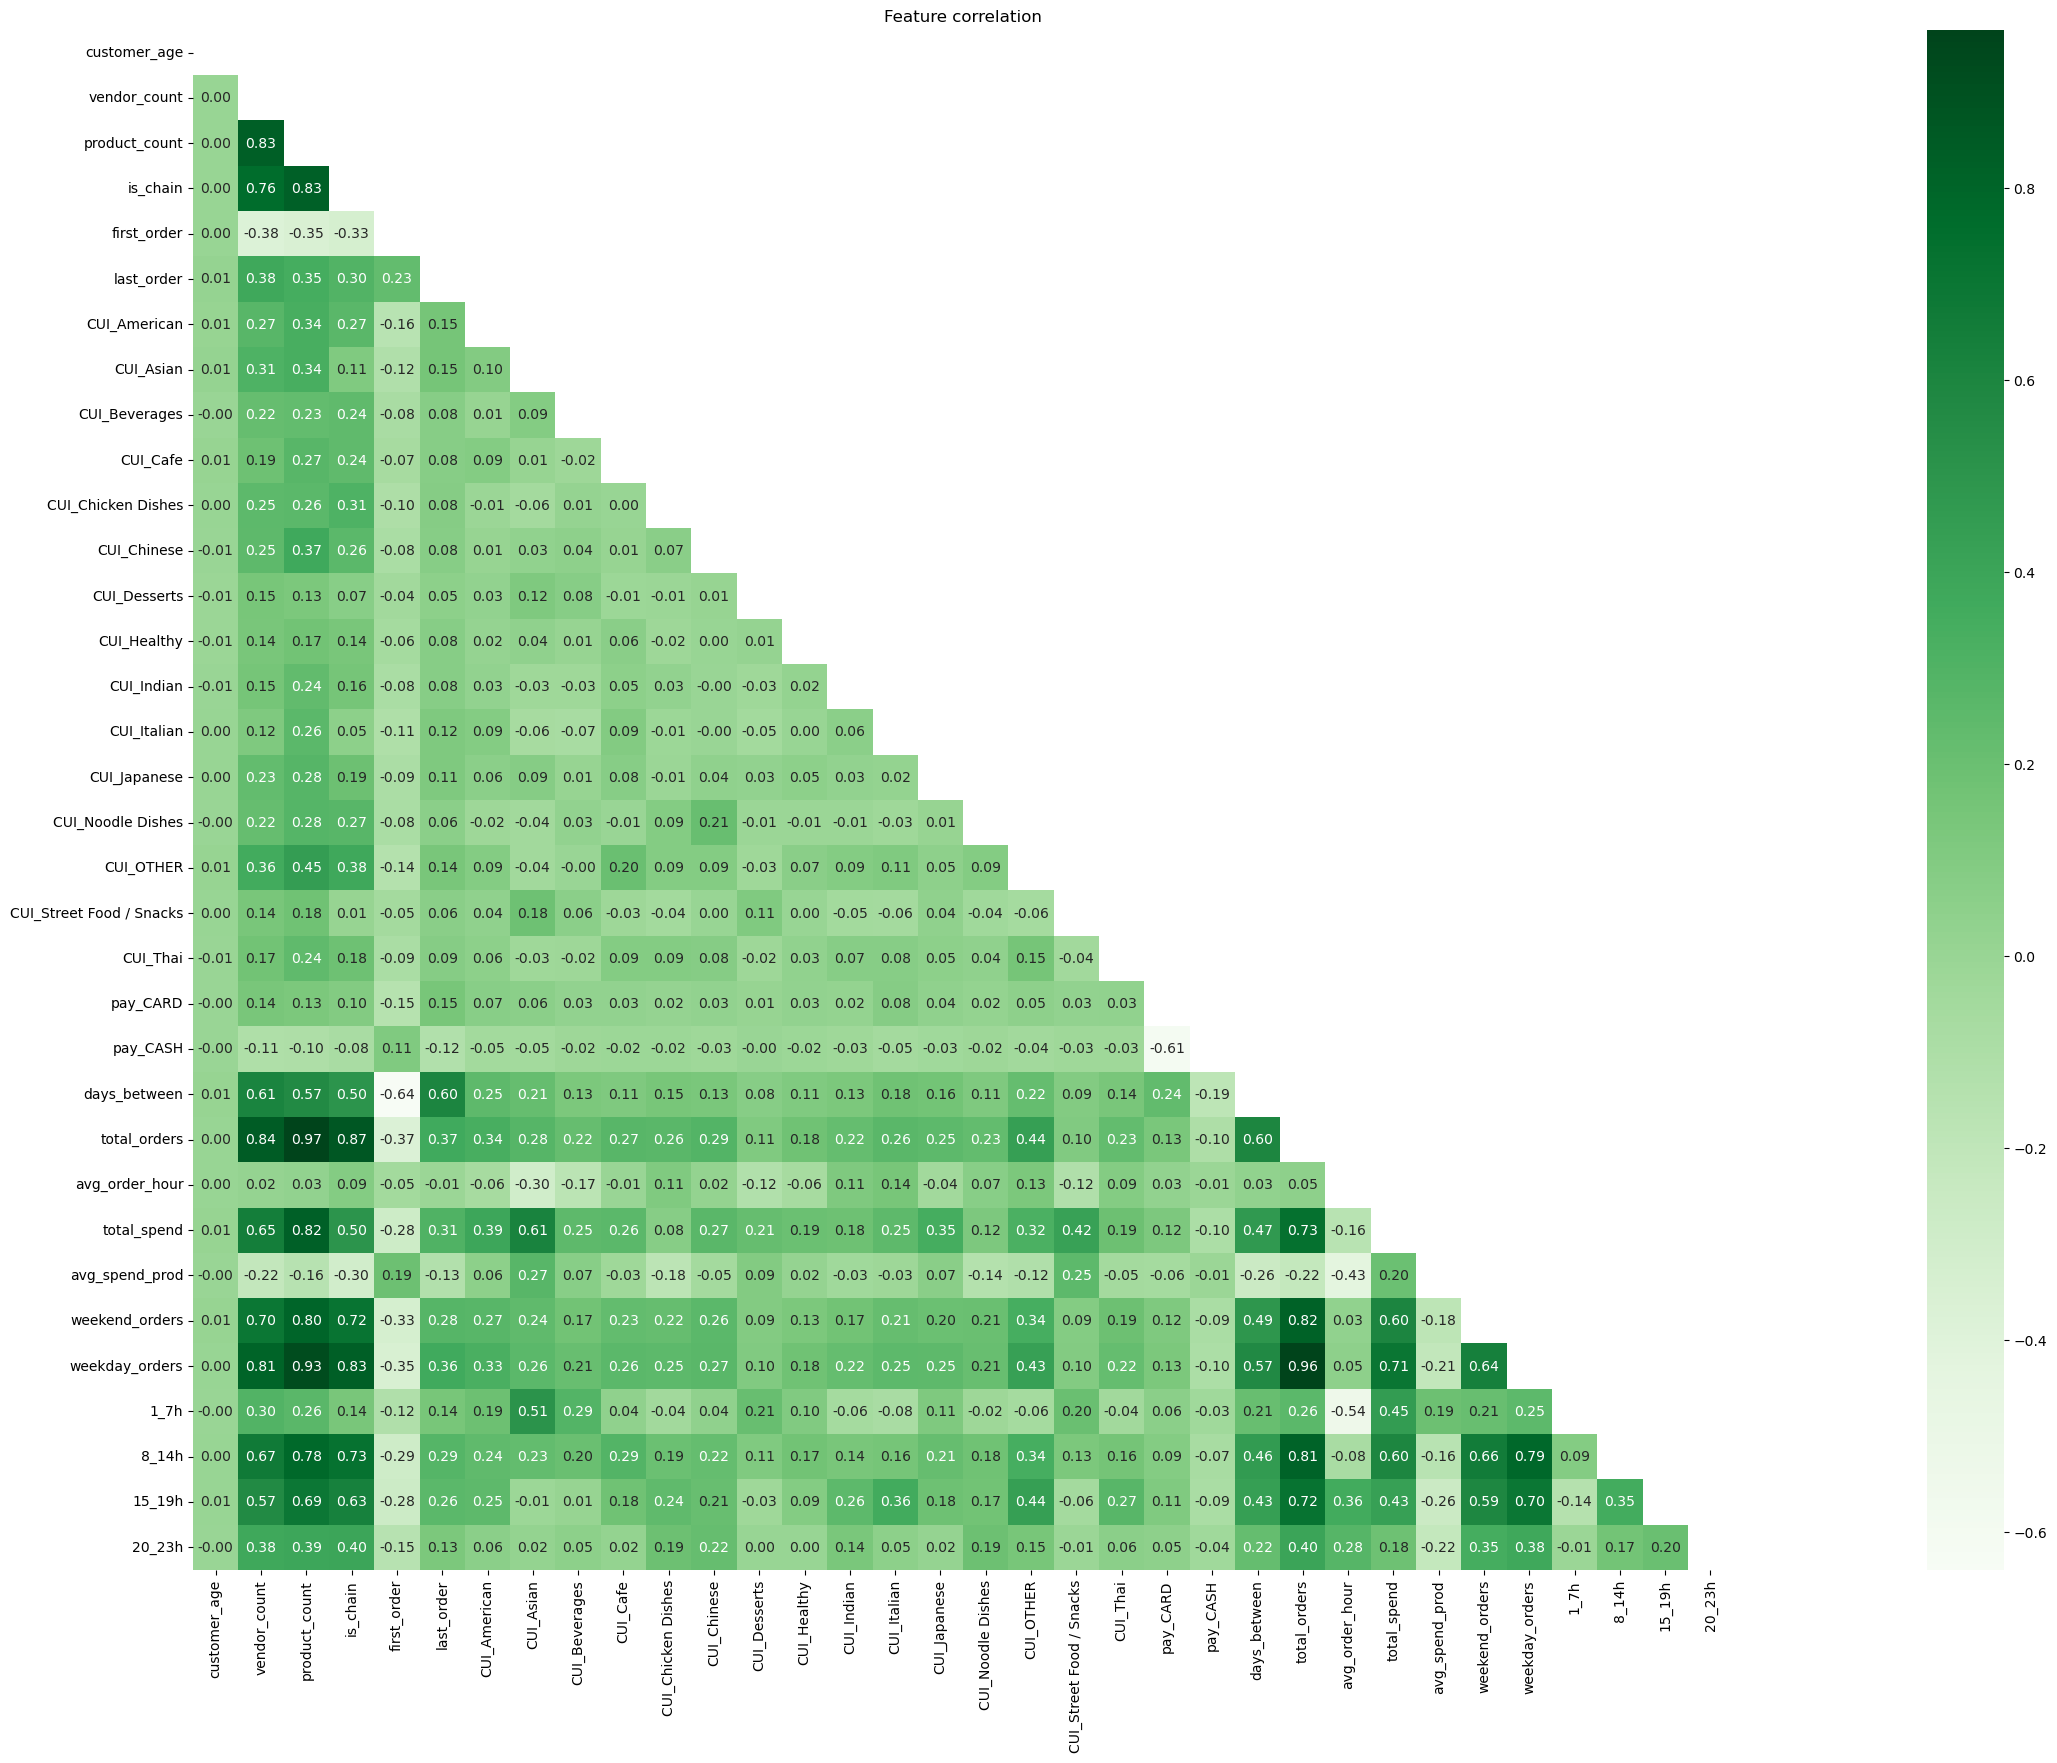

In [25]:
corr = data_num.corr(method="pearson")

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(50, 20))

sns.heatmap(data=corr, annot=True, mask=mask, cmap='Greens', fmt=".2f", square=True)

plt.title('Feature correlation')

plt.show()

Using the threshold of 0.80 (Positive and negative), there are some variables that stand out due to high correlations with several variables. The following are the variables that we can exclude due to high correlations:
* `product_count` is highly correlated to **6** variables which are: `total_orders` (0.97), `weekday_orders` (0.93), `is_chain` (0.83), `vendor_count` (0.83), `total_spend` (0.82) and `weekend_orders` (0.80).
* `total_orders` is highly correlated with **6** variables which are: `product_count` (0.97), `weekday_orders` (0.96), `is_chain` (0.87),`vendor_count` (0.83), `weekend_orders` (0.82) and`8_14h` (0.81).
* `vendor_count` is highly correlated to **3** variables which are: `total_orders` (0.84), `product_count` (0.83) and `weekday_orders` (0.81).
* `is_chain` is highly correlated to **3** variables which are: `total_orders` (0.87), `product_count` (0.83) and `weekday_orders` (0.83).
* `weekday_orders` is highly correlated with **1** variable which is `product_count` (0.93).
* `total_spend` is highly correlated with **1** variable which is `product_count` (0.82).
* `8_14h` is highly correlated with **1** variable which is `total_orders` (0.81).


Above, we can see that most of the correlations involve 2 of the variables: `product_count` and `total_orders`. As such, we should remove these variables. Additionally, we can try to train our models with and without the features `vendor_count` and `is_chain` that show high levels of correlation with 3 other variables.

<br>

# 3. Data Export

<a href="#top">Top &#129033;</a>

As a final step in this notebook, we must export the treated dataset to be used in the next phase of the project.

In [26]:
# data_copy.to_csv('./data/missing_data_filled.csv', index = True)
# data_capped.to_csv('./data/data_capped.csv', index = True)
# data_log.to_csv('./data/data_with_log.csv', index = True)